## Processing Sensor Data from Catalina Jemez CZO Green Pit 2
- Marc Berghouse 9/19/2020: Original format
- Zach Perzan 9/23/2020: Improved format and working PRISM concat


This array includes:
- apogee_SO110
- Vaisala_GMM220
- DecagonMPS2
- Decagon5TE

Issues:
- I'm not sure which water potential values are unrealistic

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

In [2]:
# Import each file individually as a dataframe and append it to a list of dataframes

infiles = ["../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_co2o2_2015.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_co2o2_2016.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_co2o2_2017.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_co2o2_2018.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_soilMTP_2015.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_soilMTP_2016.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_soilMTP_2017.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit2/Green_pit2_soilMTP_2018.csv"]


# Lists of all dataframes
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1]) # skips the 1th row (0-indexed)
    df_list.append(df)
    
prism_path = "../../raw_data/Catalina-Jemez/Catalina-Jemez_Green_PRISM.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:

columns=['ApogeeTemp_2cm.deg.C', 'ApogeeTemp_10cm.deg.C', 'ApogeeTemp_30cm.deg.C', 
            'ApogeeTemp_60cm.deg.C', 'O2_2cm.percent.0-100','O2_10cm.percent.0-100', 
            'O2_30cm.percent.0-100', 'O2_60cm.percent.0-100', 'CO2_2cm.ppm', 'CO2_10cm.ppm',
            'CO2_30cm.ppm', 'CO2_60cm.ppm', 'WaterPotential_10cm.kPa','WaterPotential_30cm.kPa',
            'DecagonMPS6Temp_10cm.deg.C','DecagonMPS6Temp_30cm.deg.C', 'SoilMoisture_10cm.m3m3',
            'SoilMoisture_30cm.m3m3', 'SoilMoisture_60cm.m3m3', 'SoilMoisture_135cm.m3m3',
            'BulkEC_10cm.dS/m', 'BulkEC_30cm.dS/m', 'BulkEC_60cm.dS/m', 'BulkEC_135cm.dS/m',
            'Decagon5TETemp_10cm.deg.C','Decagon5TETemp_30cm.deg.C', 'Decagon5TETemp_60cm.deg.C',
            'Decagon5TETemp_135cm.deg.C']


# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('4H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)

ppt = ppt.drop((pd.date_range('2015-01-01', '2015-10-23')), errors='ignore')
hourly_ppt = ppt.resample('4H').nearest()


df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

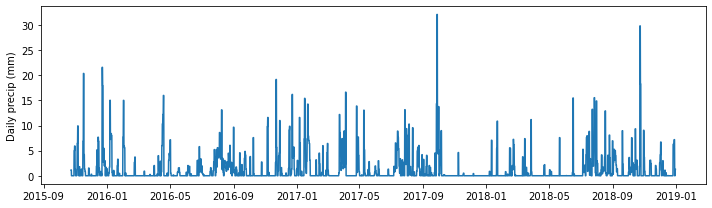

In [4]:
# Plot precip data
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

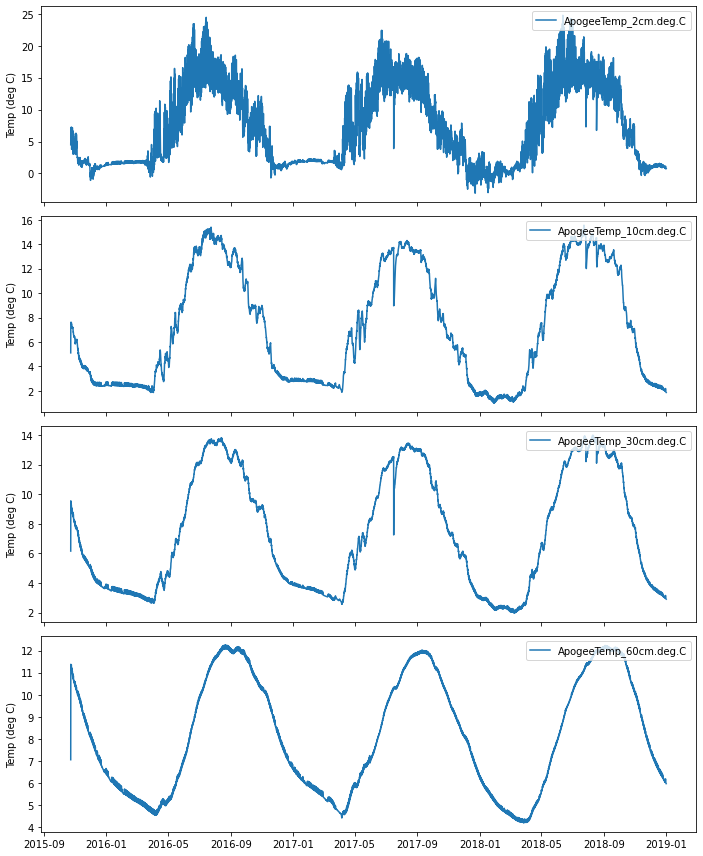

In [5]:
# Plot apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

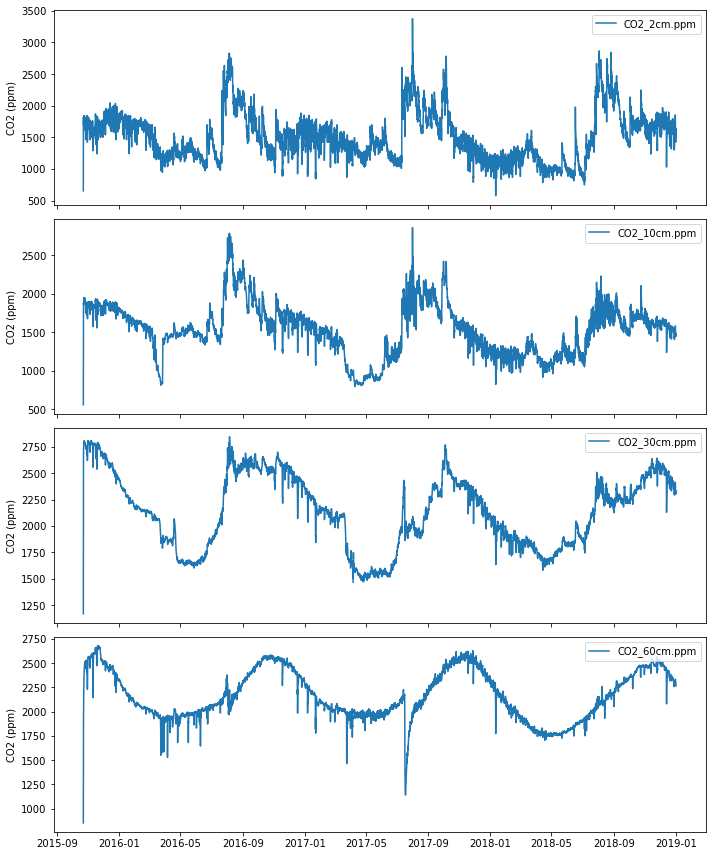

In [6]:
# Plot CO2 data
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

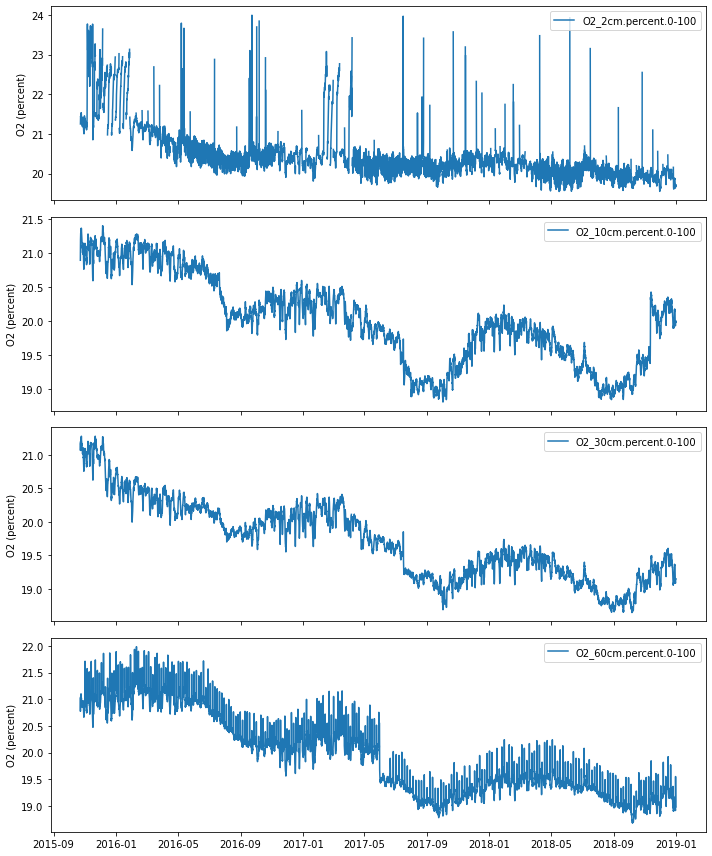

In [7]:
# Plot O2 data
df['O2_2cm.percent.0-100'].mask(df['O2_2cm.percent.0-100']>=24, inplace=True)
df['O2_10cm.percent.0-100'].mask(df['O2_10cm.percent.0-100']>=24, inplace=True)
df['O2_30cm.percent.0-100'].mask(df['O2_30cm.percent.0-100']>=24, inplace=True)
df['O2_60cm.percent.0-100'].mask(df['O2_60cm.percent.0-100']>=24, inplace=True)
#df['O2_60cm.percent.0-100.rolling_mean']=df['O2_60cm.percent.0-100'].rolling(12).mean()
#df['O2_2cm.percent.0-100.rolling_mean']=df['O2_2cm.percent.0-100'].rolling(12).mean()

o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

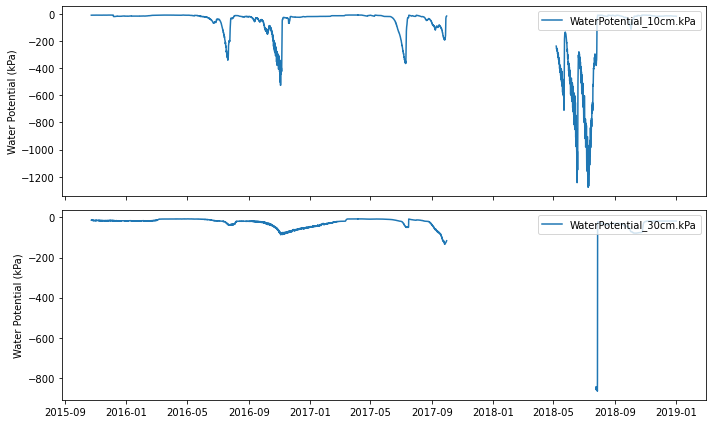

In [8]:
#Plot water potential
water_cols = [col for col in df.columns if 'Water' in col]
plot_cols(water_cols, ylabel='Water Potential (kPa)');

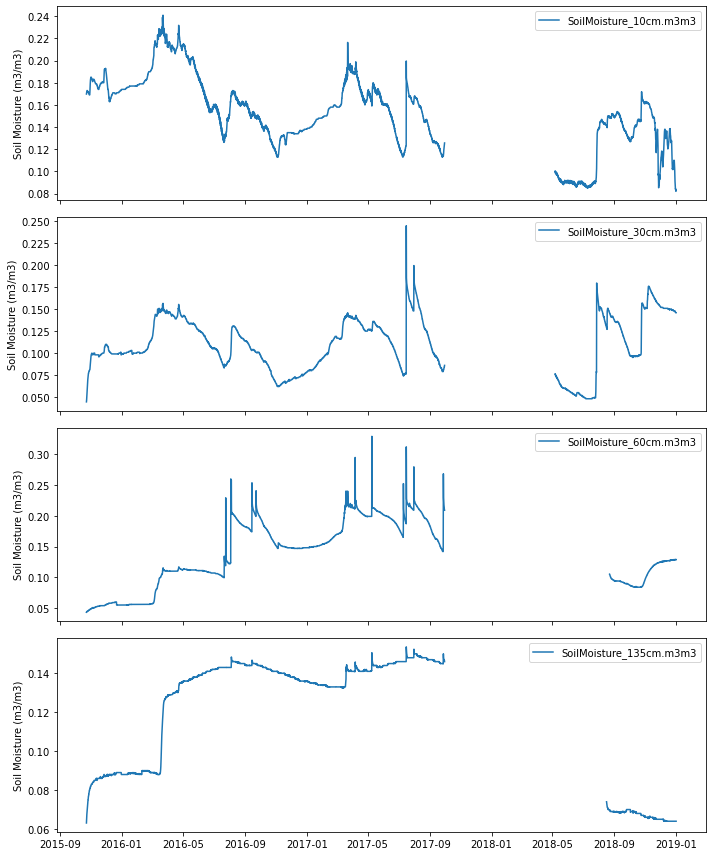

In [9]:
# Plot soil moisture data
sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)');

In [10]:
df=df.drop(columns='SoilMoisture_135cm.m3m3')


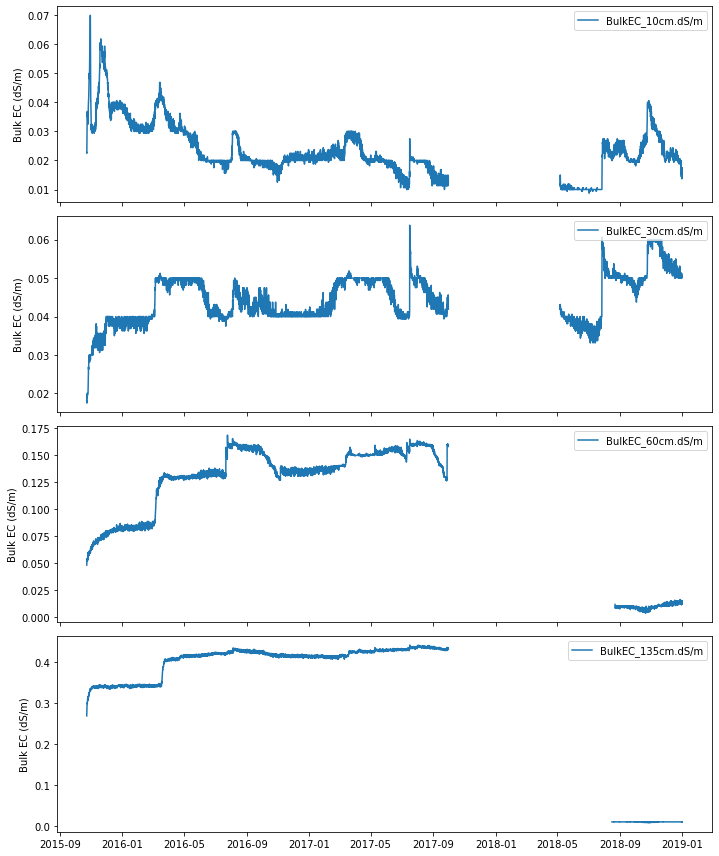

In [11]:
# Plot bulk EC
ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

In [12]:

df=df.drop(columns='BulkEC_135cm.dS/m')



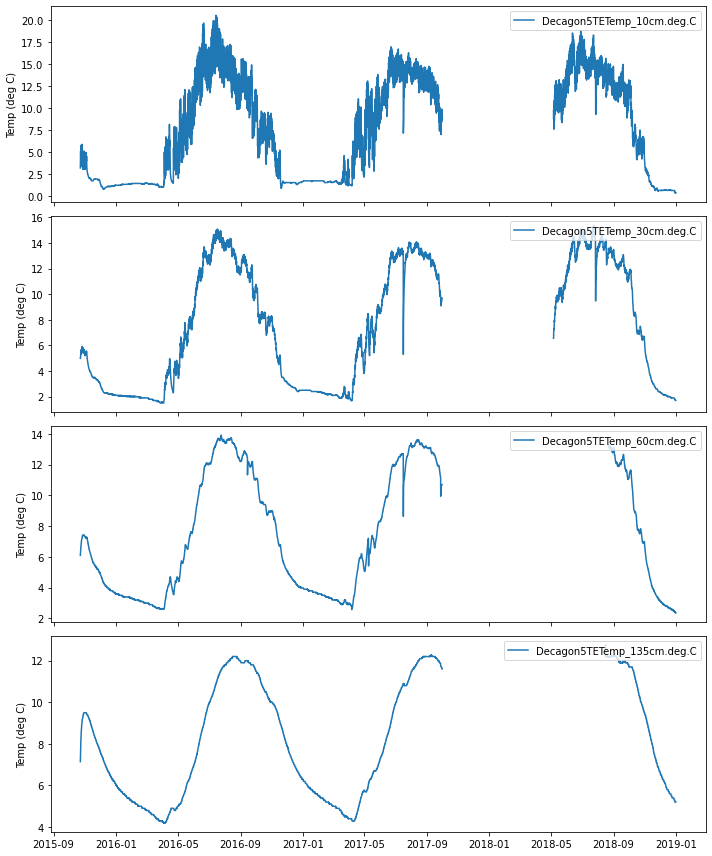

In [13]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'Decagon5TETemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [14]:
df=df.drop(columns='Decagon5TETemp_10cm.deg.C')
df=df.drop(columns='Decagon5TETemp_30cm.deg.C')
df=df.drop(columns='Decagon5TETemp_60cm.deg.C')
df=df.drop(columns='Decagon5TETemp_135cm.deg.C')
df=df.drop(columns='DecagonMPS6Temp_10cm.deg.C')
df=df.drop(columns='DecagonMPS6Temp_30cm.deg.C')




In [15]:
output=df.copy()
outfile = '../../processed_data/Catalina-Jemez/Green_Pit2_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.MST')

In [16]:
output

,ApogeeTemp_2cm.deg.C,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,O2_2cm.percent.0-100,O2_10cm.percent.0-100,O2_30cm.percent.0-100,O2_60cm.percent.0-100,CO2_2cm.ppm,CO2_10cm.ppm,...,CO2_60cm.ppm,WaterPotential_10cm.kPa,WaterPotential_30cm.kPa,SoilMoisture_10cm.m3m3,SoilMoisture_30cm.m3m3,SoilMoisture_60cm.m3m3,BulkEC_10cm.dS/m,BulkEC_30cm.dS/m,BulkEC_60cm.dS/m,PRISM_precip.mm
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2015-10-23 08:00:00,4.493636,5.106000,6.161545,7.050545,NaN,20.895000,21.186909,21.017091,653.192455,558.145636,...,851.727455,-9.572727,-14.181818,0.169818,0.044455,0.043091,0.022727,0.018182,0.048182,NaN
2015-10-23 12:00:00,7.064563,7.609500,9.552750,11.380000,21.250000,21.145250,21.064938,20.774250,1819.019563,1674.976625,...,1727.377937,-9.606250,-14.618750,0.170625,0.045125,0.043000,0.022500,0.018125,0.050625,NaN
2015-10-23 16:00:00,7.129562,7.505813,9.373563,11.307312,21.379438,21.197563,21.101812,20.956500,1717.226437,1874.213062,...,1906.319937,-9.331250,-13.675000,0.171000,0.046375,0.043813,0.024375,0.017500,0.050000,NaN
2015-10-23 20:00:00,5.817875,7.538000,9.256188,11.262938,21.446875,21.289625,21.168188,21.045000,1690.984500,1857.859875,...,2048.333813,-9.250000,-13.662500,0.171000,0.047688,0.044000,0.028125,0.019375,0.052500,NaN
2015-10-24 00:00:00,5.182500,7.573688,9.197750,11.242813,21.425625,21.290750,21.159063,21.027437,1745.966062,1890.971625,...,2144.745750,-9.206250,-13.700000,0.171313,0.049313,0.044000,0.032500,0.018750,0.052500,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 04:00:00,0.741750,1.912937,2.953000,6.000063,19.649250,19.937500,19.083063,18.915437,1574.771125,1491.114750,...,2301.010375,-17.500000,-18.468750,0.082937,0.146000,0.128875,0.013750,0.050000,0.015000,NaN
2018-12-31 08:00:00,0.706875,1.894000,2.940625,5.992062,19.723062,19.995062,19.138500,19.552062,1423.931000,1441.729688,...,2293.459937,-17.500000,-18.462500,0.082062,0.146000,0.128562,0.015625,0.050625,0.014375,NaN
2018-12-31 12:00:00,0.714375,1.877313,2.928125,5.975375,19.678750,19.971813,19.138063,19.096687,1619.201000,1461.215063,...,2275.517813,-17.500000,-18.450000,0.082250,0.146000,0.128688,0.013750,0.050625,0.015000,NaN
